# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, I will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays a cat that looks like a dog. As we can see, the algorithm predicted that this is not a dog. This project will be developed further in order to train the algorithm predict cat breeds also.

<a href="https://imgbb.com/"><img src="https://i.ibb.co/2n7Cmwc/Screenshot-from-2020-06-07-20-23-21.png" alt="Screenshot-from-2020-06-07-20-23-21" border="0"></a>

<a href="https://imgbb.com/"><img src="https://i.ibb.co/LRQy0VC/Screenshot-from-2020-06-07-20-43-46.png" alt="Screenshot-from-2020-06-07-20-43-46" border="0"></a>

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets
We have 2 datasets, one with human and one with dog images.

In [1]:
import numpy as np
from glob import glob
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
human_files[2]

'/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg'

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1
Size of faces is  (1, 4)


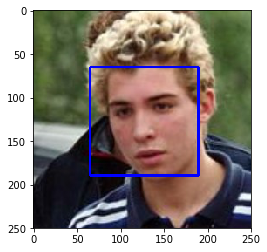

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[2])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
print("Size of faces is ",faces.shape)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

* As we can see, the detected faces in the human images is 96%.
* The detected dog faces is 17%. Ideally, we would like this percentage to be 0%.

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
vectorize = np.vectorize(face_detector)

human_detect = vectorize(human_files_short)
dog_detect = vectorize(dog_files_short)

print('Percentage of human faces found is: {:.2f}%'.format((sum(human_detect)/len(human_detect))*100))
print('Percentage of dog faces found is: {:.2f}%'.format((sum(dog_detect)/len(dog_detect))*100))

Percentage of human faces found is: 98.00%
Percentage of dog faces found is: 17.00%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if not use_cuda:
    print('CUDA is not available. Training on CPU')
    device = "cpu"
else:
    print('CUDA is available! Training on GPU')
    device = torch.device("cuda:0")
    
    VGG16 = VGG16.cuda(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 94414279.21it/s] 


CUDA is available! Training on GPU


In [7]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, we will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [8]:
from PIL import Image
import torchvision.transforms as transforms

def image_to_tensor(img_path):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
                     transforms.Resize(size=(244, 244)),
                     transforms.ToTensor()])                                   
    image = transform(image)[:3,:,:].unsqueeze(0)
    return image

def VGG16_predict(img_path):
    """
    We use a VGG16 pretrained model 
    Args: img_path: it is the path to an image
    Returns: Image index for VGG16 prediction
    """
    img = image_to_tensor(img_path)
    if use_cuda:
        img = img.cuda()
    ret = VGG16(img)
    return torch.max(ret,1)[1].item()

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we noticed that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    
    return ((prediction <= 268) & (prediction >= 151))

### (IMPLEMENTATION) Assess the Dog Detector

In [10]:
detected_dogs_human_files = 0
detected_dogs_dog_files = 0

for i in range(100):
    if dog_detector(human_files_short[i]):
        detected_dogs_human_files += 1
        print(f"This human ({i}) looks like a dog")
        human_dog_image = Image.open(human_files_short[i])
        plt.imshow(human_dog_image)
        plt.show()
    if dog_detector(dog_files_short[i]):
        detected_dogs_dog_files += 1

In [11]:
print(f"Percentage of the images in human files that have a dog is : {detected_dogs_human_files}%")
print(f"Percentage of the images in dog files that have a dog is : {detected_dogs_dog_files}%")

Percentage of the images in human files that have a dog is : 0%
Percentage of the images in dog files that have a dog is : 98%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

In [13]:
import os
from torchvision import datasets
import numpy as np
from tqdm import tqdm
from glob import glob
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image, ImageFile
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

use_cuda = torch.cuda.is_available
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
num_workers = 0
batch_size = 20
# Data directories
data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

In [14]:
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std =[0.229, 0.224, 0.225])

In [15]:
train_transforms = transforms.Compose([transforms.Resize(size=224),
                          transforms.CenterCrop(224),
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          norm])

valid_transforms = transforms.Compose([transforms.Resize(size=(256)),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       norm])

test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.ToTensor(),
                                      norm])

train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir,transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)

trainloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
validloader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)
testloader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

loaders_scratch = {
    'train': trainloader,
    'valid': validloader,
    'test': testloader
}

print('Number of train images: ', len(train_data))
print('Number of valid images: ', len(valid_data))
print('Number of test images: ', len(test_data))

Number of train images:  6680
Number of valid images:  835
Number of test images:  836


* I applied RandomResizedCrop, ColorJitter and RandomHorizontalFlip to train data. This will do image augmentation and resizing. This will prevent overfitting to the dataset. I did a resize of 256 and then center crop to (224 x 224). 
* I did not image augmentation.
* In the test data I did image resizing.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
num_classes = 133
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)        

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(7*7*128, 500) 
        self.fc2 = nn.Linear(500, num_classes)
        #dropout
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))                         
        x = self.pool(F.relu(self.conv2(x)))                      
        x = self.pool(F.relu(self.conv3(x)))
        
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [17]:
Net()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)

__About the architecture:__ 
* There are 3 convolutional layers in the architecture of the CNN created.
* There are 3 max pool layers added in the architecture.
* There are 2 fully connected layers in the architecture.
* I used ReLU activation function and a Dropout of 0.25

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [21]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [22]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, validation_last=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    if validation_last is not None:
        valid_loss_min = validation_last
    else:
        valid_loss_min = np.Inf
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # set weights to zero
            optimizer.zero_grad()
            #compute predicted outputs
            output = model(data)
            #calculate batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            #calculate batch loss
            loss = criterion(output, target)
            valid_loss = ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
           .format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if  valid_loss <= valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            print('Save model...')

    # return trained model
    return model

In [23]:
# train the model
model_scratch = train(20, loaders_scratch, 
                      model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 2.966312 	Validation Loss: 0.013521
Save model...
Epoch: 2 	Training Loss: 2.743177 	Validation Loss: 0.019539
Epoch: 3 	Training Loss: 2.565300 	Validation Loss: 0.043802
Epoch: 4 	Training Loss: 2.419586 	Validation Loss: 0.029609
Epoch: 5 	Training Loss: 2.284068 	Validation Loss: 0.055342
Epoch: 6 	Training Loss: 2.141707 	Validation Loss: 0.058137
Epoch: 7 	Training Loss: 1.977899 	Validation Loss: 0.037645
Epoch: 8 	Training Loss: 1.775625 	Validation Loss: 0.031142
Epoch: 9 	Training Loss: 1.642340 	Validation Loss: 0.032541
Epoch: 10 	Training Loss: 1.501523 	Validation Loss: 0.068132
Epoch: 11 	Training Loss: 1.331553 	Validation Loss: 0.062802
Epoch: 12 	Training Loss: 1.182778 	Validation Loss: 0.076851
Epoch: 13 	Training Loss: 1.066501 	Validation Loss: 0.084119
Epoch: 14 	Training Loss: 0.934257 	Validation Loss: 0.078443
Epoch: 15 	Training Loss: 0.827669 	Validation Loss: 0.083177
Epoch: 16 	Training Loss: 0.724334 	Validation Loss: 0.067036
Epo

### (IMPLEMENTATION) Test the Model

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0
    correct = 0
    total = 0

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
model = test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.824139


Test Accuracy: 15% (127/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

In [25]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### Model Architecture

We use transfer learning to create a CNN to classify dog breed. We save the model as the variable `model_transfer`.

In [26]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
## TODO: Specify model architecture 
model_transfer = models.vgg19(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
print(model_transfer)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 92266533.59it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

__About the architecture:__ 
* For this CNN architecture, we use the pre-trained model of VGG19. This architecture is very good for image recognition problems, in our case for the dog breed classifier. The model predicted very efficiently with 81% Test Accuracy: (682/836).
* This model is already trained to recognize 1000 categories of ImageNet competition. 
* It is noteworthy for its extremely simple structure, being a simple linear chain of layers, with all the convolutional layers having a kernel size of 3x3. Despite this simple structure, it achieves competitive classification accuracy compared to more complicated nets (such as GoogLeNet), although at the cost of slower evaluation speed and much larger net size. (as refered on: https://resources.wolframcloud.com/NeuralNetRepository/resources/VGG-19-Trained-on-ImageNet-Competition-Data)
* In order to make this model work in our specific dog breed classifier, we will change the final classifier to 133, the classes of the dog breeds. We won't change the number of layers, they will remain the same.

In [44]:
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.classifier[6] = nn.Linear(4096, 133, bias=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

### Specify Loss Function and Optimizer

In [45]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier[6].parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate the model in the code cell below. We will  [save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [46]:
# train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.647929 	Validation Loss: -0.028964
Save model...
Epoch: 2 	Training Loss: 0.641598 	Validation Loss: -0.006166
Epoch: 3 	Training Loss: 0.507112 	Validation Loss: -0.007695
Epoch: 4 	Training Loss: 0.432591 	Validation Loss: 0.001984
Epoch: 5 	Training Loss: 0.386928 	Validation Loss: 0.004279
Epoch: 6 	Training Loss: 0.350056 	Validation Loss: 0.000788
Epoch: 7 	Training Loss: 0.330682 	Validation Loss: -0.003805
Epoch: 8 	Training Loss: 0.324895 	Validation Loss: -0.003286
Epoch: 9 	Training Loss: 0.302046 	Validation Loss: 0.001748
Epoch: 10 	Training Loss: 0.286392 	Validation Loss: -0.001081


### Test the Model

In [49]:
test(loaders_scratch, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.581141


Test Accuracy: 85% (716/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

We write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [84]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = image_to_tensor(img_path)
    model = model_transfer.cpu()
    model.eval()
    index = torch.argmax(model(img))

    return class_names[index]

---
<a id='step5'></a>
## Step 5: Write the Algorithm

We will now write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

###  Write the Algorithm

In [99]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path, title="Picture detected!"):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(title)
    plt.show()
    if(dog_detector(img_path)):
        prediction =  predict_breed_transfer(img_path)
        print("Hello dog! It looks like you are a {0}".format(prediction))
    elif(face_detector(img_path)):
        predicted_dog = predict_breed_transfer(img_path)
        print("Hello human, if you were dog you would be: {}".format(predicted_dog))
    else:
        print("No human or dog detected! Maybe wrong image?")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, we will take the new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test the Algorithm on Sample Images!

The output is better than I expected, it classified all the dog breeds correclty and also the images of humans seems to look like the dog mentioned. Althought, we could improve some things in the algorithm in the future. I tested the algorithm with cat images and fortunately the algorithm did not recognized them as dogs like other algorithms that I tested in the past. This is a good sign. The algorithm recognizes human also, which is very good.
* We could increase the accuracy of the model. This can be done with many different ways (for example adding more conventional layers). Also we can test different pre-trained networks to see which one performs better.
* The algorithm could be trained to handle better when there are more than 1 dog in the picture.
* It would be good if the algorithm could predict also speecies and breeds of other animals like for example a cat.
* Also, we could train the algorithm to recognize facial features in the face of a dog or a human.
* It would be good idea of improvement to recognize some famous people (like for example Johny Depp which I tested in my code.)
* Another idea is to train the algorithm to recognize if there is a male or a female in the image.
* We could also add some more classes in the model sinc there are 190 officially recognized dog breeds.

### Let's test the algorithm in some random images of our dataset. 
As we can see, the algorithm recognizes human faces and predicts which breed of dog these people could be if they were dogs.
I the breed prediction, we can see that there are some errors but overall the algoritm predicts good results.

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


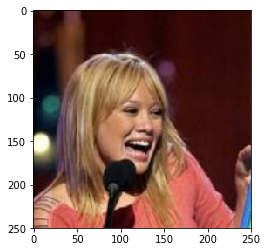

Hello human, if you were dog you would be: Afghan hound


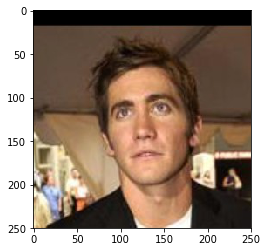

Hello human, if you were dog you would be: Afghan hound


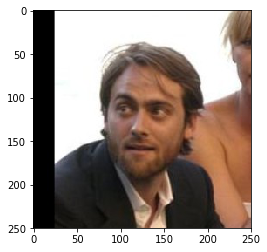

Hello human, if you were dog you would be: Afghan hound


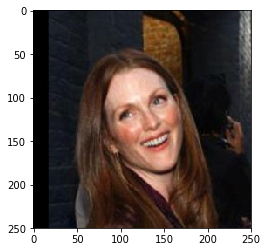

No human or dog detected! Maybe wrong image?


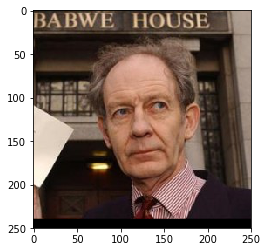

Hello human, if you were dog you would be: Canaan dog


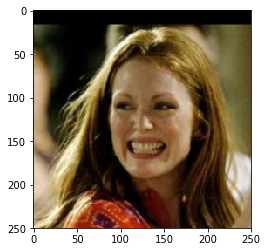

Hello human, if you were dog you would be: Afghan hound


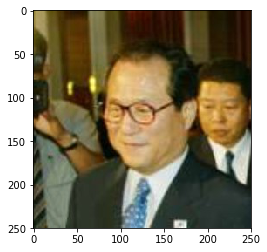

Hello human, if you were dog you would be: Basenji


In [78]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import random
%time

for image in random.sample(list(human_files_short), 7):
    predicted_breed = predict_breed_transfer(image)
    run_app(image)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


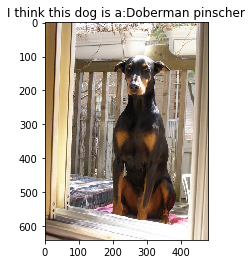

Hello dog! It looks like you are a Doberman pinscher


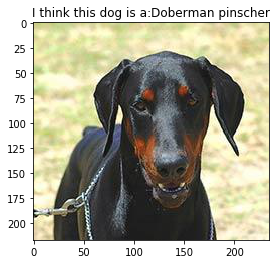

Hello dog! It looks like you are a Doberman pinscher


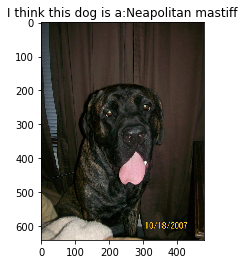

No human or dog detected! Maybe wrong image?


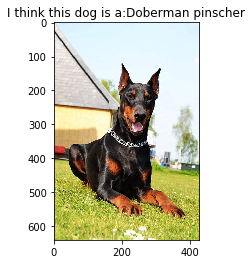

Hello dog! It looks like you are a Doberman pinscher


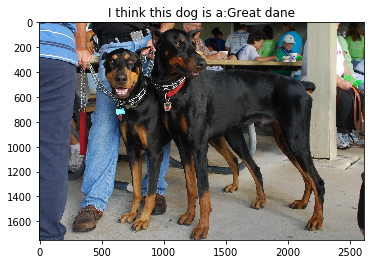

Hello dog! It looks like you are a Great dane


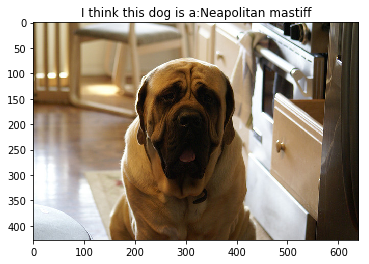

Hello dog! It looks like you are a Neapolitan mastiff


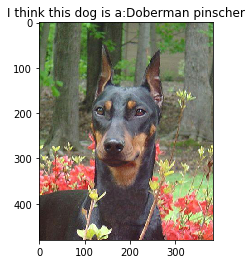

Hello dog! It looks like you are a Doberman pinscher


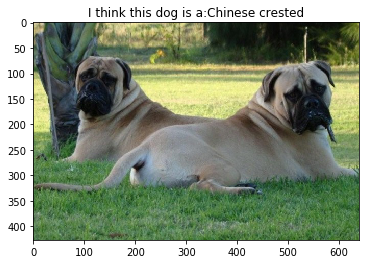

No human or dog detected! Maybe wrong image?


In [91]:
%time

for image in random.sample(list(dog_files_short), 8):
    predicted_breed = predict_breed_transfer(image)
    run_app(image, title = f"I think this dog is a:{predicted_breed}")

### The algorithm looks to work good on our dataset.  However we see that there is an error when the picture has more than 1 dog.
Let's test it now in some custom images:

### Let's now test it in some human dog and othe animal images.

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


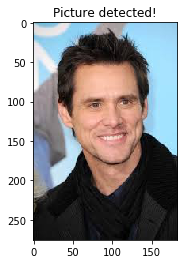

Hello human, if you were dog you would be: Dachshund


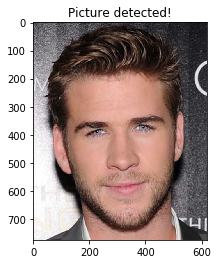

Hello human, if you were dog you would be: Afghan hound


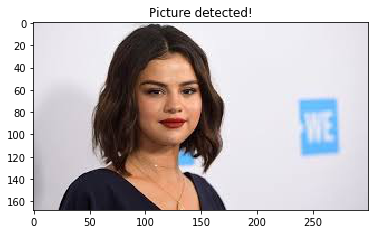

Hello human, if you were dog you would be: Afghan hound


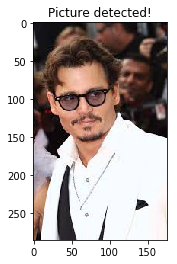

Hello human, if you were dog you would be: Collie


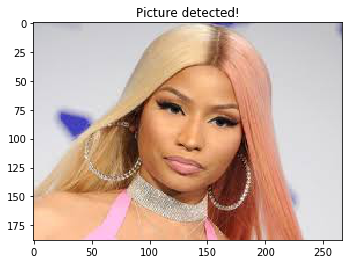

Hello human, if you were dog you would be: Maltese


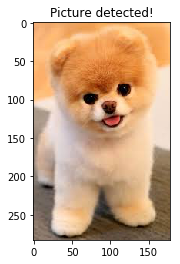

Hello dog! It looks like you are a Pomeranian


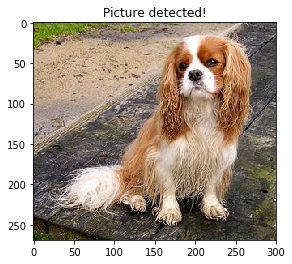

Hello dog! It looks like you are a Cavalier king charles spaniel


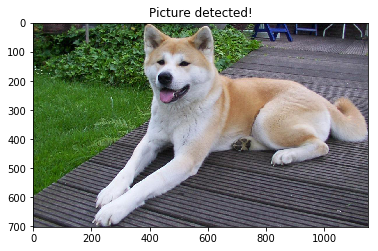

Hello dog! It looks like you are a Akita


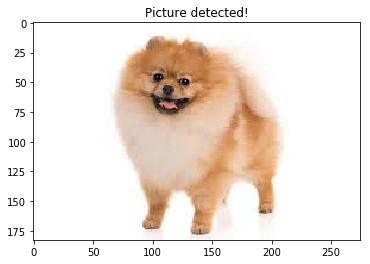

Hello dog! It looks like you are a Pomeranian


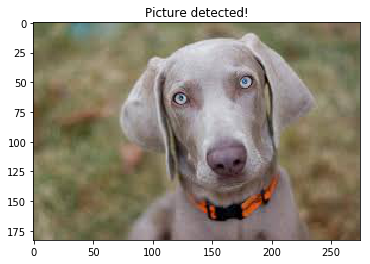

Hello dog! It looks like you are a German shorthaired pointer


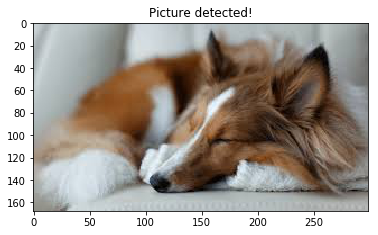

Hello dog! It looks like you are a Icelandic sheepdog


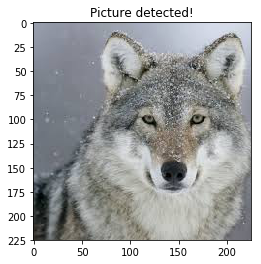

No human or dog detected! Maybe wrong image?


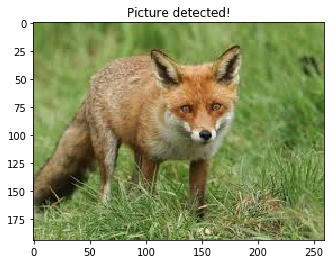

Hello human, if you were dog you would be: Icelandic sheepdog


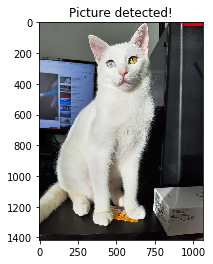

No human or dog detected! Maybe wrong image?


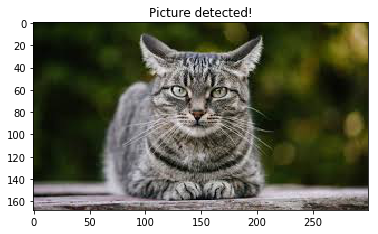

No human or dog detected! Maybe wrong image?


In [100]:
%time

human_files = ['images/2.jpeg',
               'images/3.jpg',
               'images/gomez.jpeg',
               'images/johnydepp.jpeg',
               'images/minaj.jpeg']
dog_files = ['images/dog.jpeg',
             'images/CavalierKgChas2_wb.jpg',
             'images/Akita_inu.jpeg',
             'images/dog2.jpeg',
             'images/download.jpeg',
             'images/colley.jpeg']

other_animals = ['images/wolf.jpeg',
                 'images/fox.jpeg',
                 'images/be.jpeg',
                 'images/cat.jpeg']

for file in np.hstack((human_files, dog_files, other_animals)):
    prediction = predict_breed_transfer(image)
    run_app(file)

### Let's try now the algorithm in some other animal pictures.
It would be intersting to test the model in an animal that looks like a dog (a wolf for example).
Nice! The algorithm recognized the wolf like no human or dog. That's good.
Also the algorithm classified the fox like a human, which we could consider like a misclassification. However classified correctly the cat images.

### This is an image of a cat who looks like a dog! Let's test this image in our algorithm :) 

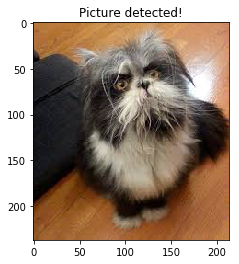

No human or dog detected! Maybe wrong image?


In [101]:
run_app("images/catlikedog.jpeg")

As we can see, the algorithm recognized correctly that this is not a dog picture. A human maybe would be confused and say that this is a dog, which is a good sign for our algorithm.